In [10]:
# Step 1: Importing Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Step 2: Downloading Historical Price Data
tickers = ["QQQ", "VGT", "XLK", "TLT"]
start_date = "2010-01-01"
end_date = "2024-12-31"

data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.dropna(inplace=True)
data.to_csv("price_data.csv")


/var/folders/zz/y2_h9x0s2378k58hfr7vvwmh0000gn/T/ipykernel_83830/2916426056.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  4 of 4 completed


In [3]:
#Step 3: Computing Daily Returns & Cumulative Returns
returns = data.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()


In [4]:
#Step 4: Computing Indicators (Momentum, SMA)
momentum = data.pct_change(20)
sma_50 = data.rolling(window=50).mean()
sma_200 = data.rolling(window=200).mean()

momentum.to_csv("momentum_20d.csv")
sma_50.to_csv("sma_50.csv")
sma_200.to_csv("sma_200.csv")


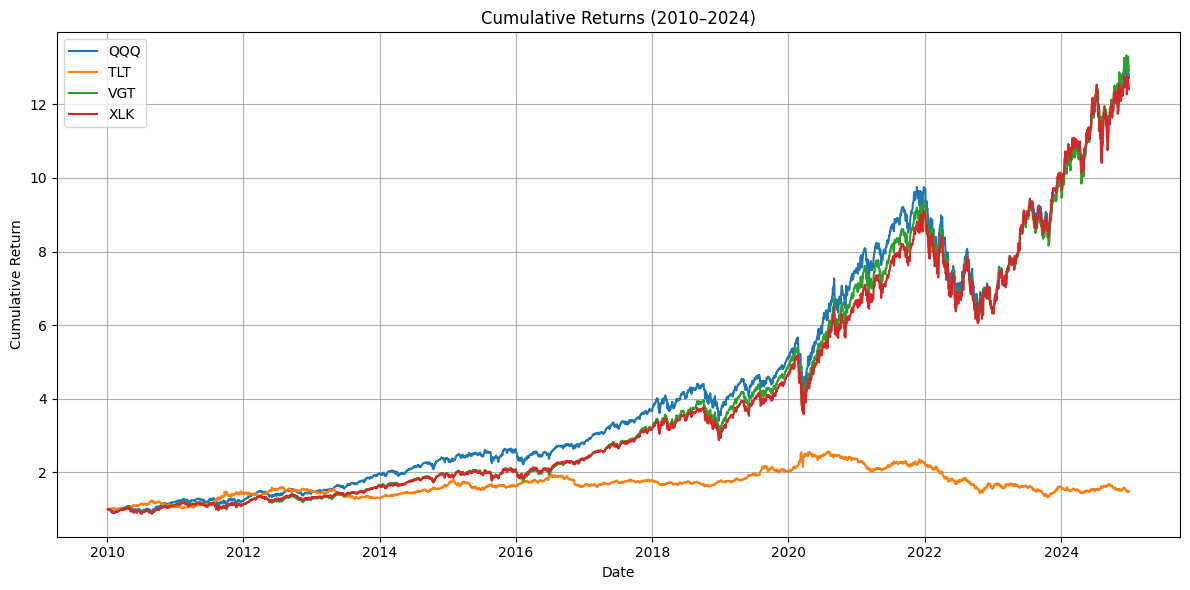

In [5]:
#Step 5: Visualizing Cumulative Returns
plt.figure(figsize=(12, 6))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
plt.title("Cumulative Returns (2010–2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cumulative_returns.png")
plt.show()


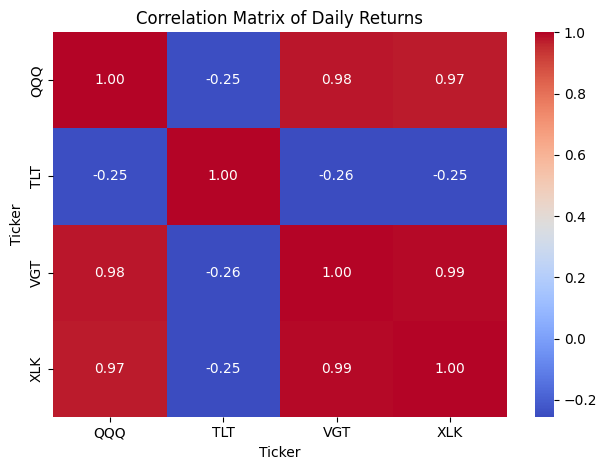

In [6]:
#Step 6: Correlation Matrix Heatmap
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()

correlation_matrix.to_csv("correlation_matrix.csv")


/var/folders/zz/y2_h9x0s2378k58hfr7vvwmh0000gn/T/ipykernel_83830/1135710505.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()
/var/folders/zz/y2_h9x0s2378k58hfr7vvwmh0000gn/T/ipykernel_83830/1135710505.py:11: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  signals = momentum_score.idxmax(axis=1).shift(1).dropna()


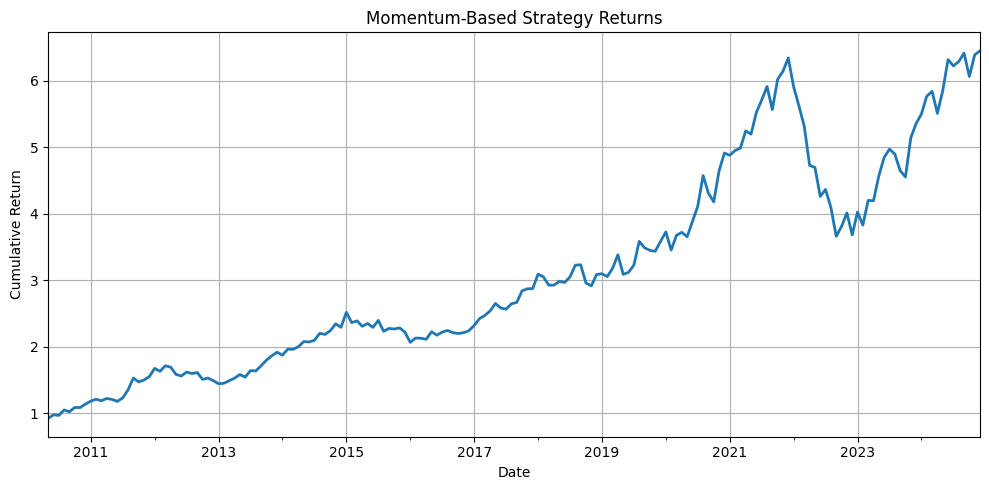

In [14]:
#Step 7: Momentum-Based Strategy Allocation

# Resample data to monthly prices (last trading day of each month)
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change()

# Calculate 3-month momentum (past 3-month % change)
momentum_score = monthly_prices.pct_change(3)

# For each month, pick the ETF with the highest momentum (shift to avoid look-ahead bias)
signals = momentum_score.idxmax(axis=1).shift(1).dropna()

# Extract corresponding returns using loop-based lookup
strategy_returns = []
for date, ticker in signals.items():
    try:
        strat_return = monthly_returns.loc[date, ticker]
        strategy_returns.append((date, strat_return))
    except KeyError:
        # Handle missing data safely
        continue

# Convert to Series and compute cumulative returns
strategy_returns = pd.Series(
    {date: ret for date, ret in strategy_returns},
    name="Strategy Return"
)

strategy_cum_returns = (1 + strategy_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 5))
strategy_cum_returns.plot(title="Momentum-Based Strategy Returns", lw=2)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.savefig("strategy_returns.png")
plt.show()

# Export results
strategy_returns.to_csv("strategy_returns.csv")
strategy_cum_returns.to_csv("strategy_cumulative_returns.csv")

In [19]:
# Load previously saved strategy returns
strategy_returns = pd.read_csv("strategy_returns.csv", index_col=0, parse_dates=True)
strategy_returns = strategy_returns.squeeze()  # Ensure it's a Series, not a DataFrame

#Step 8: Performance Evaluation
def compute_performance_metrics(returns: pd.Series):
    metrics = {}
    metrics['Total Return'] = (1 + returns).prod() - 1
    metrics['Annualized Return'] = (1 + returns.mean()) ** 12 - 1
    metrics['Annualized Volatility'] = returns.std() * np.sqrt(12)
    
    ann_return = metrics['Annualized Return']
    ann_volatility = metrics['Annualized Volatility']
    
    metrics['Sharpe Ratio'] = ann_return / ann_volatility if ann_volatility != 0 else np.nan

    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    metrics['Max Drawdown'] = drawdown.min()
    
    return pd.Series(metrics)

# Compute metrics
performance_metrics = compute_performance_metrics(strategy_returns)

# Display results
print(performance_metrics.to_frame(name="Momentum Strategy Metrics"))

# Save to CSV
performance_metrics.to_frame(name="Momentum Strategy Metrics").to_csv("strategy_performance_metrics.csv")


                       Momentum Strategy Metrics
Total Return                            5.455087
Annualized Return                       0.150412
Annualized Volatility                   0.162913
Sharpe Ratio                            0.923268
Max Drawdown                           -0.422514
